# Investigation of batch effects between two atlas studies

**Keywords**

<ins>*Transcripts Per Million (TPM)*</ins>: The sum of ALL normalized transcript expression values is divided by 1,000,000, to create a scaling factor. Each transcript's normalized expression is divided by the scaling factor, which results in the TPM value.

<ins>*Fragments Per Kilobase of transcript per Million mapped reads (FPKM)*</ins>: Simple expression level normalization method. The FPKM normalizes read count based on gene length and the total number of mapped reads.

<ins>*Counts Per Million mapped reads (CPM)*</ins>: The number of raw reads mapped to a transcript, scaled by the number of sequencing reads in your sample, multiplied by a million. It normalizes RNA-seq data for sequencing depth but not gene length

# 0. Set up

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybiomart
import scanpy as sc
from scipy.stats import gaussian_kde
import seaborn as sns

from IPython import display

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# Fetch protein coding genes.
dataset = pybiomart.Dataset(name = 'hsapiens_gene_ensembl', host = 'http://www.ensembl.org')
ensembl_gene_biotypes = dataset.query(attributes = ['ensembl_gene_id', "gene_biotype"])
protein_coding_genes = ensembl_gene_biotypes[ensembl_gene_biotypes["Gene type"] == "protein_coding"].dropna()
protein_coding_genes = set(protein_coding_genes["Gene stable ID"])

# 1. Ingest adjusted-median Tabula Sapiens expression data

The data used in this section has been computed and saved previously.

In [3]:
# Read in data from a previously saved pickle.
tabula = pd.read_pickle('final_tabula_adjusted_median_drop_na.pkl', compression = 'gzip')

# Set NaN expression to 0.
tabula.fillna(0, inplace=True)

# 2. Ingest GTEx V8 data

Data used for the bulk RNA-seq expression is the [GTEx Consortium](https://www.ebi.ac.uk/gxa/experiments/E-MTAB-5214/Results) experiment which sampled data from 54 human tissue samples. The GTEx dataset is large and internally consistent like the Tabula Sapiens Atlas, meaning it does not require batch correction within it.

GTEx Analysis V8 is found under the [Bulk tissue expression](https://www.gtexportal.org/home/downloads/adult-gtex) tab and can be found as a TSV file containing the median counts for each gene for each tissue allowing comparison to the single-cell RNA-seq data from Tabula Sapiens.

In [4]:
# Read the data, skipping 2 metadata rows.
GTEx = pd.read_table(
    'bulk-gex_v8_rna-seq_GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz', 
    skiprows = 2
)

# Set Ensembl ID as row index.
GTEx = GTEx.drop('Description', axis = 1).set_index('Name')

# Transpose matrix so it resembles the Tabula Sapiens one.
GTEx = GTEx.T

# Drop Ensembl gene version, leaving only the ID.
GTEx.rename(columns={
    c: c[:15] for c in GTEx.columns
}, inplace=True)

# Replace low expression with zero.
GTEx[GTEx < 1.0] = 0.0

# 3. Normalise Tabula and GTEx data

In [5]:
dfs = {"tabula": tabula, "GTEx": GTEx}

for df_name, df in dfs.items():
    # Keep only protein coding genes.
    genes_to_keep = list(protein_coding_genes & set(df.columns))
    df = df[genes_to_keep]
    
    # Drop the genes where expression is zero across all tissues/cell types.
    df = df.loc[:, (df != 0).any(axis=0)]
    
    # Normalise the expression so that the sum across each tissue (GTEx) or cell type (Tabula) is 1,000,000.
    df_sum = df.sum(axis=1)
    df = df.div(df_sum, axis=0) * 1000000

    # Store the dataframe.
    dfs[df_name] = df

tabula, GTEx = dfs["tabula"], dfs["GTEx"]

# 4. Compare expression of housekeeping genes

For a subset of six housekeeping genes, we look at normalised (TPM) expressions in all GTEx tissues and all Tabula Sapiens cell types.

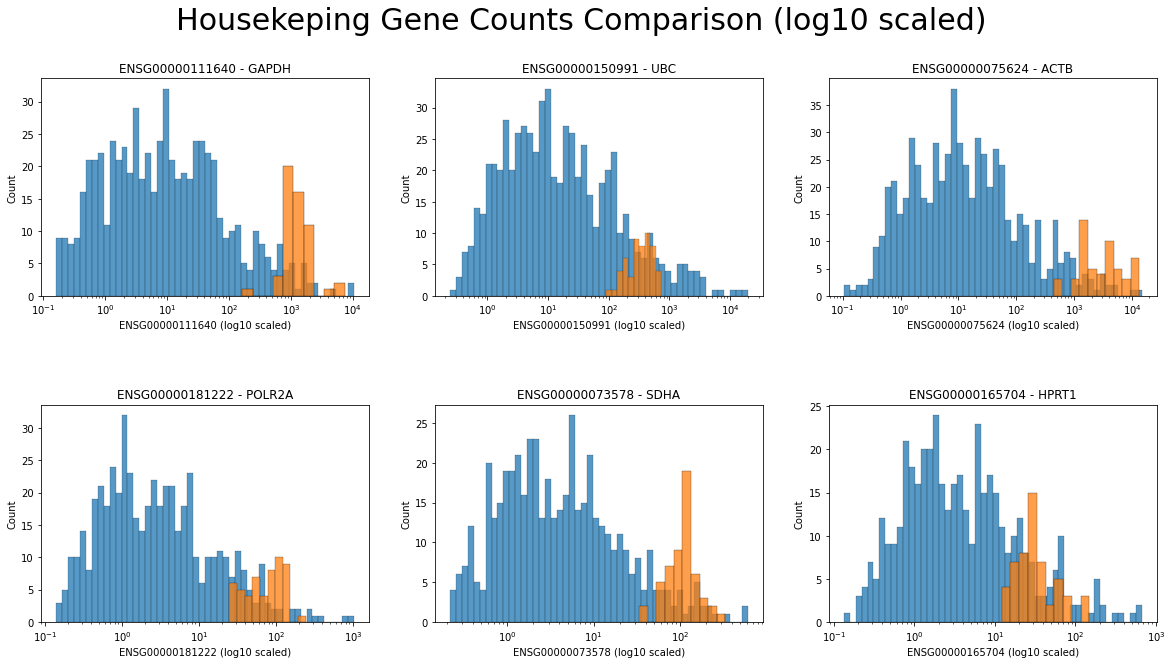

In [6]:
def gene_expression_dist(gene, ax):
    sns.histplot(data = tabula, x = gene, bins = 50, log_scale = True, ax = ax)
    sns.histplot(data = GTEx, x = gene, bins = 10, log_scale = True, ax = ax)
    ax.set_xlabel(f'{gene} (log10 scaled)')

housekeeping_genes = {'ENSG00000111640' : 'GAPDH', 'ENSG00000150991' : 'UBC', 'ENSG00000075624' : 'ACTB', 
                      'ENSG00000181222' : 'POLR2A', 'ENSG00000073578' : 'SDHA', 'ENSG00000165704' : 'HPRT1'}

# Create subplot grid.
fig, axes = plt.subplots(2,3)
ax = axes.flatten()

for i, gene in enumerate(housekeeping_genes.keys()):
    gene_expression_dist(gene, ax[i])
    ax[i].set_title(f'{gene} - {housekeeping_genes.get(gene)}')

fig.subplots_adjust(hspace=0.5)
fig.set_figheight(10)
fig.set_figwidth(20)
fig.suptitle('Housekeping Gene Counts Comparison (log10 scaled)', fontsize = 30)
plt.show()

# 5. Identify shared tissues between Tabula and GTEx

We are interested in the tissues which are shared across both datasets. Both Tabula and GTEx have mappings to UBERON IDs. For GTEx these mappings can be found here: [gtex_v8_tissues.tsv](https://github.com/opentargets/curation/blob/master/mappings/biosystem/gtex_v8_tissues.tsv).

However, in many cases the correspondence is not exact, because while tissues are conceptually the same, they are grounded to different ontology codes. In many cases, Tabula uses a high level code (example: liver, UBERON:0002107), while GTEx uses a very specific code which best corresponds to the sampling site (example: right liver lobe, UBERON:0001114).

Because we only have a small amount of tissue, it makes sense to just set up the mapping manually. We are mapping everything into GTEx names for convenience.

In [7]:
# Manually map Tabula UBERON IDs to GTEx tissue names.
tabula_to_gtex_lut = {
    # Tabula UBERON ID: GTEx tissue name
    "UBERON:0002190": "Adipose - Subcutaneous",
    "UBERON:0000947": "Artery - Aorta",
    "UBERON:0001621": "Artery - Coronary",
    "UBERON:0002107": "Liver",
    "UBERON:0002048": "Lung",
    "UBERON:0002367": "Prostate",
    "UBERON:0002106": "Spleen",
    "UBERON:0000995": "Uterus",
    "UBERON:0000178": "Whole Blood",
}
shared_tissues = set(tabula_to_gtex_lut.values())

# Rename and filter Tabula columns.
tabula = tabula.rename(index=tabula_to_gtex_lut)
tabula = tabula.loc[tabula.index.get_level_values('tissue').isin(shared_tissues)]

# Filter GTEx columns.
GTEx = GTEx.loc[GTEx.index.isin(shared_tissues)]

# 6. Check the data before processing

In [8]:
tabula

ENSG00000205084  \
tissue      cell_type                                                             
Whole Blood basophil                                                   0.000000   
            cd4-positive, alpha-beta memory t cell                     0.000000   
            cd4-positive, alpha-beta t cell                           77.331155   
            cd8-positive, alpha-beta cytokine secreting eff...         0.000000   
            cd8-positive, alpha-beta t cell                          134.225294   
...                                                                         ...   
Prostate    nkt cell                                                   0.000000   
            smooth muscle cell                                         9.840273   
            sperm                                                      0.000000   
            stromal cell                                               0.000000   
            t cell                                                     0.000000   

                                                                ENSG00000254122  \
tissue      cell_type                                                             
Whole Blood basophil                                                        0.0   
            cd4-positive, alpha-beta memory t cell                          0.0   
            cd4-positive, alpha-beta t cell                                 0.0   
            cd8-positive, alpha-beta cytokine secreting eff...              0.0   
            cd8-positive, alpha-beta t cell                                 0.0   
...                                                                         ...   
Prostate    nkt cell                                                        0.0   
            smooth muscle cell                                              0.0   
            sperm                                                           0.0   
            stromal cell                                                    0.0   
            t cell                                                          0.0   

                                                                ENSG00000217930  \
tissue      cell_type                                                             
Whole Blood basophil                                                   0.000000   
            cd4-positive, alpha-beta memory t cell                    20.818972   
            cd4-positive, alpha-beta t cell                           15.756412   
            cd8-positive, alpha-beta cytokine secreting eff...        33.504897   
            cd8-positive, alpha-beta t cell                           62.785257   
...                                                                         ...   
Prostate    nkt cell                                                   0.000000   
            smooth muscle cell                                         0.000000   
            sperm                                                      0.000000   
            stromal cell                                               0.000000   
            t cell                                                     0.000000   

                                                                ENSG00000176974  \
tissue      cell_type                                                             
Whole Blood basophil                                                   0.000000   
            cd4-positive, alpha-beta memory t cell                     1.761906   
            cd4-positive, alpha-beta t cell                            0.683079   
            cd8-positive, alpha-beta cytokine secreting eff...         1.369586   
            cd8-positive, alpha-beta t cell                            1.319580   
...                                                                         ...   
Prostate    nkt cell                                                   0.000000   
            smooth muscle cell                                         1.9117

In [9]:
GTEx

Name,ENSG00000205084,ENSG00000254122,ENSG00000217930,ENSG00000176974,ENSG00000162620,ENSG00000172262,ENSG00000112763,ENSG00000196664,ENSG00000117448,ENSG00000168067,...,ENSG00000143801,ENSG00000140798,ENSG00000122852,ENSG00000137507,ENSG00000172663,ENSG00000179163,ENSG00000130653,ENSG00000174628,ENSG00000111700,ENSG00000122386
Adipose - Subcutaneous,5.742285,8.852370,15.387358,45.462543,0.0,11.915053,38.654814,0.000000,55.891689,8.218189,...,14.797021,0.0,0.000000,203.650289,12.766811,37.132769,15.047878,10.771796,0.000000,17.343289
Artery - Aorta,7.172441,10.709010,16.243089,11.630758,0.0,10.068949,49.722065,0.000000,69.219649,9.344999,...,15.396900,0.0,0.000000,134.490860,12.892694,64.834914,11.956462,4.396138,0.000000,18.576046
Artery - Coronary,7.312255,9.184997,17.288652,13.001315,0.0,10.771291,50.127948,0.000000,62.665061,9.389168,...,15.010030,0.0,0.000000,192.224438,13.929261,52.041921,9.497383,6.117073,0.000000,17.663152
Liver,0.000000,0.000000,20.313514,211.240531,0.0,4.438672,8.099406,0.000000,91.623567,2.240711,...,6.462488,0.0,0.000000,8.067213,12.753421,28.425436,7.637624,0.000000,48.183389,9.676184
Lung,6.711948,10.859485,23.513821,16.690703,0.0,11.744884,53.029006,0.000000,78.239779,27.149453,...,19.513940,0.0,2166.578969,203.546541,14.889595,48.887879,8.829233,7.313624,0.000000,19.245432
Prostate,7.980607,4.004867,20.841478,18.245234,0.0,12.021846,42.898063,0.000000,75.801489,12.219889,...,23.698965,0.0,0.000000,47.390074,28.581785,46.198888,37.986985,7.073036,0.000000,28.488685
Spleen,3.152901,2.018751,23.569688,36.899560,0.0,14.257974,83.315771,3.018111,93.786454,47.454256,...,24.276051,0.0,0.000000,61.664601,21.077241,79.609713,13.183744,2.924374,0.000000,14.980610
Uterus,13.198104,11.527994,22.904302,15.757715,0.0,16.162695,60.252793,0.000000,70.289698,14.090853,...,27.099630,0.0,0.000000,75.952702,15.226703,40.332239,22.379116,9.809085,0.000000,30.147010
Whole Blood,0.000000,0.000000,10.213503,4.264781,0.0,2.914978,31.798523,0.000000,20.842027,17.434798,...,1.848665,0.0,0.000000,0.000000,4.471523,13.536495,0.000000,0.000000,0.000000,0.000000


# 7. Ingest cell counts

In [10]:
# This data has been computed previously.
counts = pd.read_pickle('tabula_counts_tissue_sparse.pkl', compression = 'gzip')

# Drop the actual expression data which we don't need.
counts = counts.iloc[:, 0:2]

# Map to GTEx tissue names.
counts["tissue"].replace(tabula_to_gtex_lut, inplace=True)

# Subset to only shared tissues defined above.
counts = counts[counts["tissue"].isin(shared_tissues)]

# Group by and count for each combination of tissue+cell type.
counts = counts.groupby(["tissue", "cell_type"], observed=True).size().reset_index(name="count")

# Set an index on tissue and cell_type columns.
counts.set_index(["tissue", "cell_type"], inplace=True)

counts

count
tissue      cell_type                                                
Whole Blood basophil                                               29
            cd4-positive, alpha-beta memory t cell                949
            cd4-positive, alpha-beta t cell                      2863
            cd8-positive, alpha-beta cytokine secreting eff...   1493
            cd8-positive, alpha-beta t cell                      1322
...                                                               ...
Prostate    nkt cell                                              175
            smooth muscle cell                                    285
            sperm                                                  11
            stromal cell                                           32
            t cell                                                586

[173 rows x 1 columns]

# 8. Compute and plot Tabula "synthetic tissues" versus GTEx

The idea is simple: in the Tabula Sapiens dataset, for each tissue, we have:
* For each cell type, adjusted-median expression values computed previously
* The proportion of this cell type in the whole tissue, obtained from individual cell counts

This means that we can construct a "synthetic tisue" from median cell expressions, thus in some sense recreating a bulk experiment _in silico._

In [11]:
def plot_tissue(tissue_name, histogram_ax=None, kde_ax=None):
    """Plot the histogram & KDE scatterplot for GTEx and Tabula Sapiens adjusted-median data across a single tissue.
    
    Input:
        tissue_name (string): Tissue name to plot.
        
    Output:
        histogram (plot): expression distribution for both datasets on a log-scale axis.
        KDE scatterplot (plot): KDE scatterplot of GTEx vs Tabula expressions on log-scale axis."""
    
    if (tissue_name not in tabula.index) | (tissue_name not in GTEx.index):
        raise Exception("The tissue name supplied is not present in one/both of the datasets.")
    else:
        # Select just the data for the tissue we are processing.
        tabula_tissue = tabula.loc[tissue_name]
        GTEx_tissue = pd.DataFrame(GTEx.loc[tissue_name])

        # Drop genes with zero expression.
        tabula_tissue = tabula_tissue[tabula_tissue > 0].dropna(axis=1, how='all')
        GTEx_tissue = GTEx_tissue[GTEx_tissue > 0].dropna()

        # # Remove genes which are only expressed in a few cell types in Tabula.
        # tabula_tissue = tabula_tissue.loc[:, (~ tabula_tissue.isna()).sum() >= 3]
        
        # Identify shared genes.
        tabula_genes = set(tabula_tissue.columns)
        GTEx_genes = set(GTEx_tissue.index)
        shared_genes = set(tabula_tissue.columns) & set(GTEx_tissue.index)
        tabula_only_genes = tabula_genes - shared_genes
        GTEx_only_genes = GTEx_genes - shared_genes
        print(
            f"Non-zero gene count for {tissue_name}: "
            f"{len(tabula_only_genes)} only in Tabula, "
            f"{len(GTEx_only_genes)} only in GTEx, "
            f"{len(shared_genes)} shared"
        )

        # Filter so that only shared genes remain.
        tabula_tissue = tabula_tissue.filter(items = shared_genes, axis = 1)
        GTEx_tissue = GTEx_tissue.filter(items = shared_genes, axis = 0)
        
        # Calculate proportion of each cell type in this tissue.
        cell_type_counts = counts.loc[tissue_name]
        cell_type_counts['proportion'] = cell_type_counts['count'] / cell_type_counts['count'].sum()
        
        # Weigh calculated expression in each cell based on proportions.
        proportion_list = cell_type_counts['proportion'].to_list()
        weighted_tissue = tabula_tissue.mul(proportion_list, axis = 0)

        # Calculate sum of weighted median expressions across all cell types to make is comparable to GTEx.
        sum_expression = pd.DataFrame(weighted_tissue.sum(axis=0)).rename(columns={0: "Tabula"})

        # Create a dataframe with weighted Tabula expressions and GTEx expressions.
        expression_df = pd.concat([sum_expression, GTEx_tissue.rename(columns={tissue_name: "GTEx"})], axis = 1)

        # Normalise counts between the datasets.
        for column in ("Tabula", "GTEx"):
            expression_df[column] = (expression_df[column] / expression_df[column].sum()) * 1000000

        # If the axes are not provided, return the expression df and do not plot anything.
        if not (histogram_ax and kde_ax):
            return expression_df
            
        # Log-transform.
        log10_scaled_expression_df = np.log10(expression_df + 0.0001)
        
        # Plot histogram of normalised expressions on log-scale axis.
        sns.histplot(data = log10_scaled_expression_df, x = "Tabula", bins = 100, ax = histogram_ax, label = 'Tabula')
        sns.histplot(data = log10_scaled_expression_df, x = "GTEx", bins = 100, ax = histogram_ax, label = 'GTEx')
        histogram_ax.set_xlabel('log10 of expression)')
        histogram_ax.set_ylabel('Frequency')
        histogram_ax.legend()
        histogram_ax.set_title(f'{tissue_name} Expression')

        # Plot KDE scatter plot.
        x = log10_scaled_expression_df["GTEx"]
        y = log10_scaled_expression_df["Tabula"]
        xy = np.vstack([x, y])
        z = gaussian_kde(xy)(xy)
        plt.set_cmap('jet')
        kde_ax.scatter(x, y, c=z, s=5)
        kde_ax.set_xlabel('GTEx expression')
        kde_ax.set_ylabel('Tabula expression')
        kde_ax.set_title(f'{tissue_name} KDE scatterplot')
        kde_ax.set_xlim(-1, 4)
        kde_ax.set_ylim(-1, 4)

Non-zero gene count for Adipose - Subcutaneous: 2106 only in Tabula, 184 only in GTEx, 12941 shared
Non-zero gene count for Artery - Aorta: 1996 only in Tabula, 229 only in GTEx, 12807 shared
Non-zero gene count for Artery - Coronary: 1820 only in Tabula, 227 only in GTEx, 13004 shared
Non-zero gene count for Liver: 2581 only in Tabula, 191 only in GTEx, 11362 shared
Non-zero gene count for Lung: 2559 only in Tabula, 131 only in GTEx, 13844 shared
Non-zero gene count for Prostate: 1821 only in Tabula, 335 only in GTEx, 13639 shared
Non-zero gene count for Spleen: 2254 only in Tabula, 292 only in GTEx, 13026 shared
Non-zero gene count for Uterus: 209 only in Tabula, 5062 only in GTEx, 8346 shared
Non-zero gene count for Whole Blood: 4865 only in Tabula, 46 only in GTEx, 9851 shared


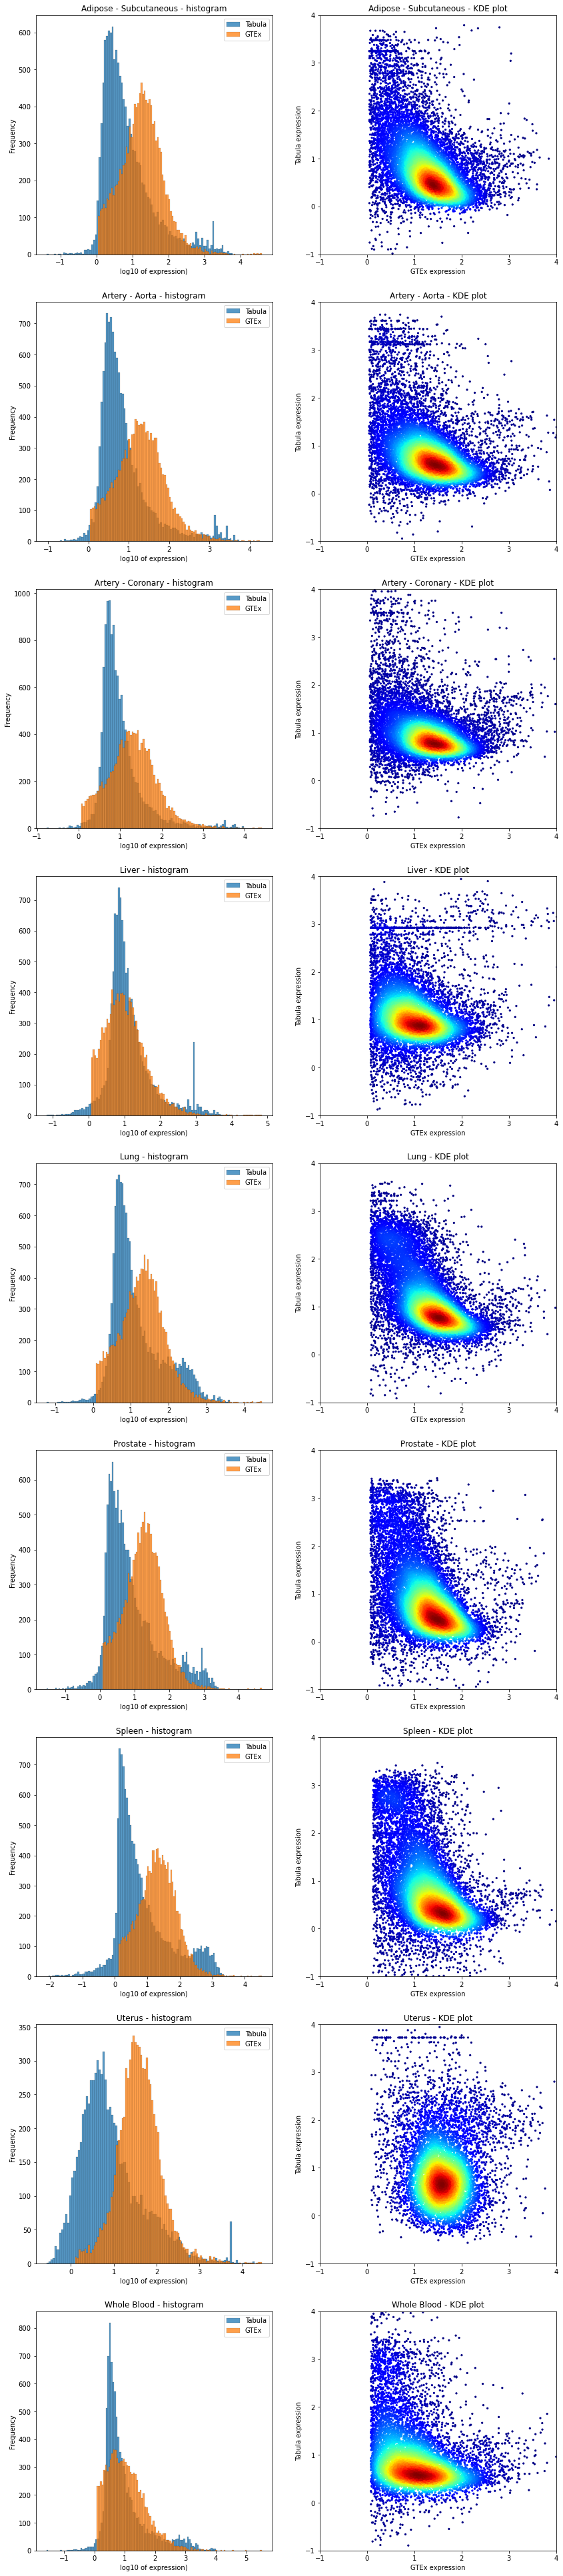

In [12]:
# Create 9x2 grid for subplots.
fig, axes = plt.subplots(9, 2)

for i, tissue_name in enumerate(sorted(shared_tissues)):
# for i, tissue_name in enumerate(["Prostate"]):
    ax = axes[i]
    plot_tissue(tissue_name, ax[0], ax[1])
    ax[0].set_title(f"{tissue_name} - histogram")
    ax[1].set_title(f"{tissue_name} - KDE plot")

fig.subplots_adjust(hspace=0.2)
fig.set_figheight(70)
fig.set_figwidth(14)
plt.show()

# 9. Investigate the outliers

Clearly, there are high discrepancies in gene expression between Tabula and GTEx. Using prostate as an example, we can visualise this:

Non-zero gene count for Prostate: 1821 only in Tabula, 335 only in GTEx, 13639 shared


(array([   5.,   17.,   31.,   95.,  349.,  790., 1435., 1960., 2032.,
        1806., 1343.,  912.,  702.,  529.,  435.,  384.,  358.,  269.,
         152.,   35.]),
 array([-3.7389984 , -3.38678157, -3.03456474, -2.68234792, -2.33013109,
        -1.97791426, -1.62569744, -1.27348061, -0.92126378, -0.56904695,
        -0.21683013,  0.1353867 ,  0.48760353,  0.83982035,  1.19203718,
         1.54425401,  1.89647084,  2.24868766,  2.60090449,  2.95312132,
         3.30533814]),
 <BarContainer object of 20 artists>)

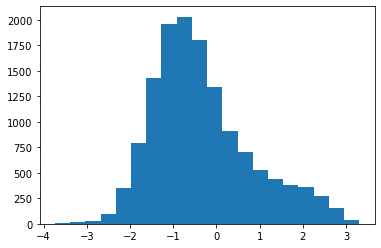

In [13]:
df = plot_tissue("Prostate")
df["ratio_log10"] = np.log10(df.Tabula / df.GTEx)
plt.hist(df.ratio_log10, bins=20)

Let's now highlight some of the genes with the highest discrepancies. For each gene, we show all non-zero TPM counts in Tabula cell types, as well as a visualised distribution summary taken directly from Tabula Sapiens website. Note that the units in those figures are ln(1+CPM).

In [14]:
def show_tabula(gene):
    return tabula[gene][tabula[gene] > 0]

## ENSG00000160200 — CBS, involved in amino acid metabolism

In [15]:
show_tabula("ENSG00000160200")

tissue                  cell_type                          
Whole Blood             neutrophil                              618.193706
Artery - Aorta          fibroblast                             1940.726070
Artery - Coronary       fibroblast                              377.489254
Lung                    adventitial cell                         39.010873
                        macrophage                             1801.124308
                        type ii pneumocyte                       57.978243
Liver                   hepatocyte                             1193.841221
Adipose - Subcutaneous  fibroblast                             1434.994745
Prostate                basal cell of prostate epithelium      2170.075662
                        epithelial cell                        1108.174562
                        luminal cell of prostate epithelium    2654.352458
Name: ENSG00000160200, dtype: float64

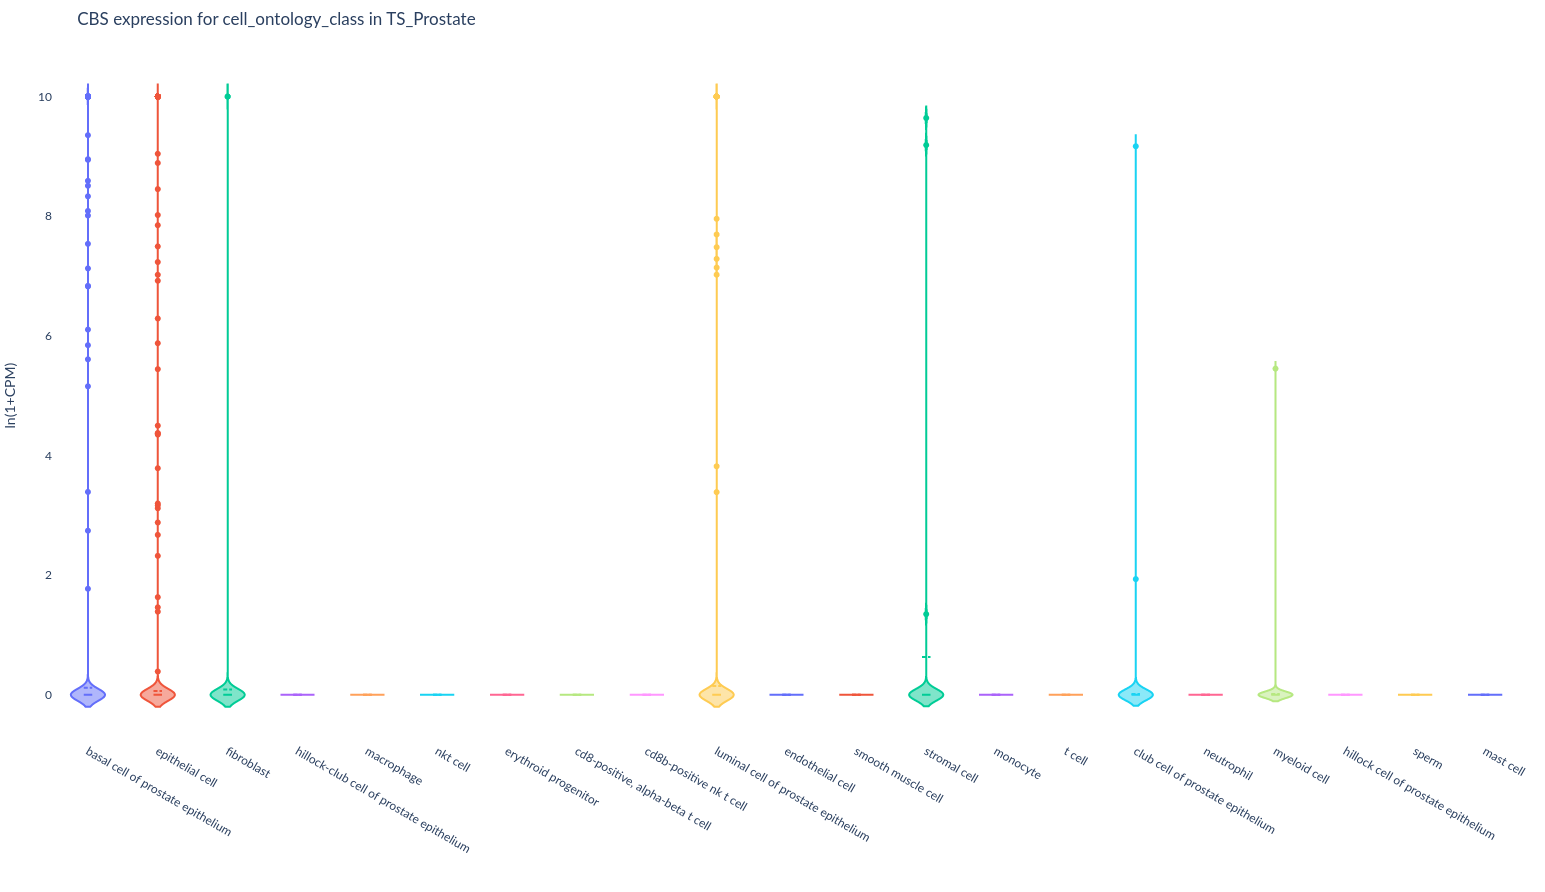

## ENSG00000105366 — SIGLEC8, involved in immune response

In [16]:
show_tabula("ENSG00000105366")

tissue             cell_type             
Artery - Aorta     macrophage                  1078.924863
Artery - Coronary  macrophage                   139.635740
Lung               basophil                    2787.246369
                   macrophage                   293.843914
                   non-classical monocyte      3523.297375
Spleen             classical monocyte            40.091374
                   macrophage                  7502.408698
Liver              endothelial cell           12407.526374
                   macrophage                  1055.133529
Prostate           macrophage                 24187.380448
                   monocyte                  177808.403969
                   myeloid cell               24126.170203
Name: ENSG00000105366, dtype: float64

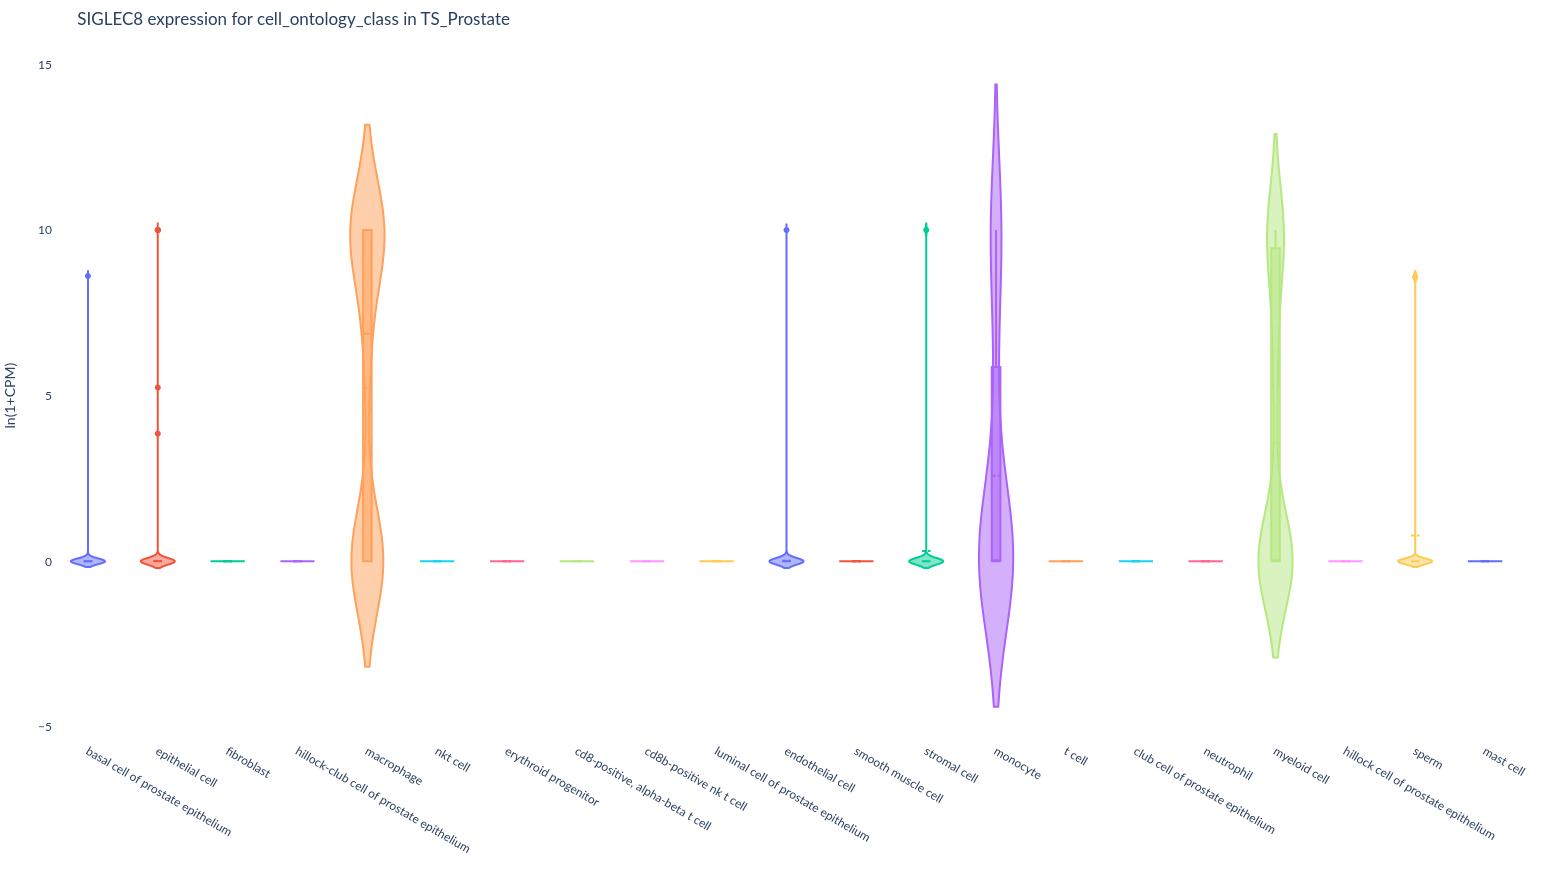

## ENSG00000145198 — VWA5B2

In [17]:
show_tabula("ENSG00000145198")

tissue    cell_type                               
Lung      lung ciliated cell                           1626.761979
Prostate  basal cell of prostate epithelium            2170.075662
          epithelial cell                              1108.174562
          hillock-club cell of prostate epithelium    21682.782099
          luminal cell of prostate epithelium            34.748340
Name: ENSG00000145198, dtype: float64

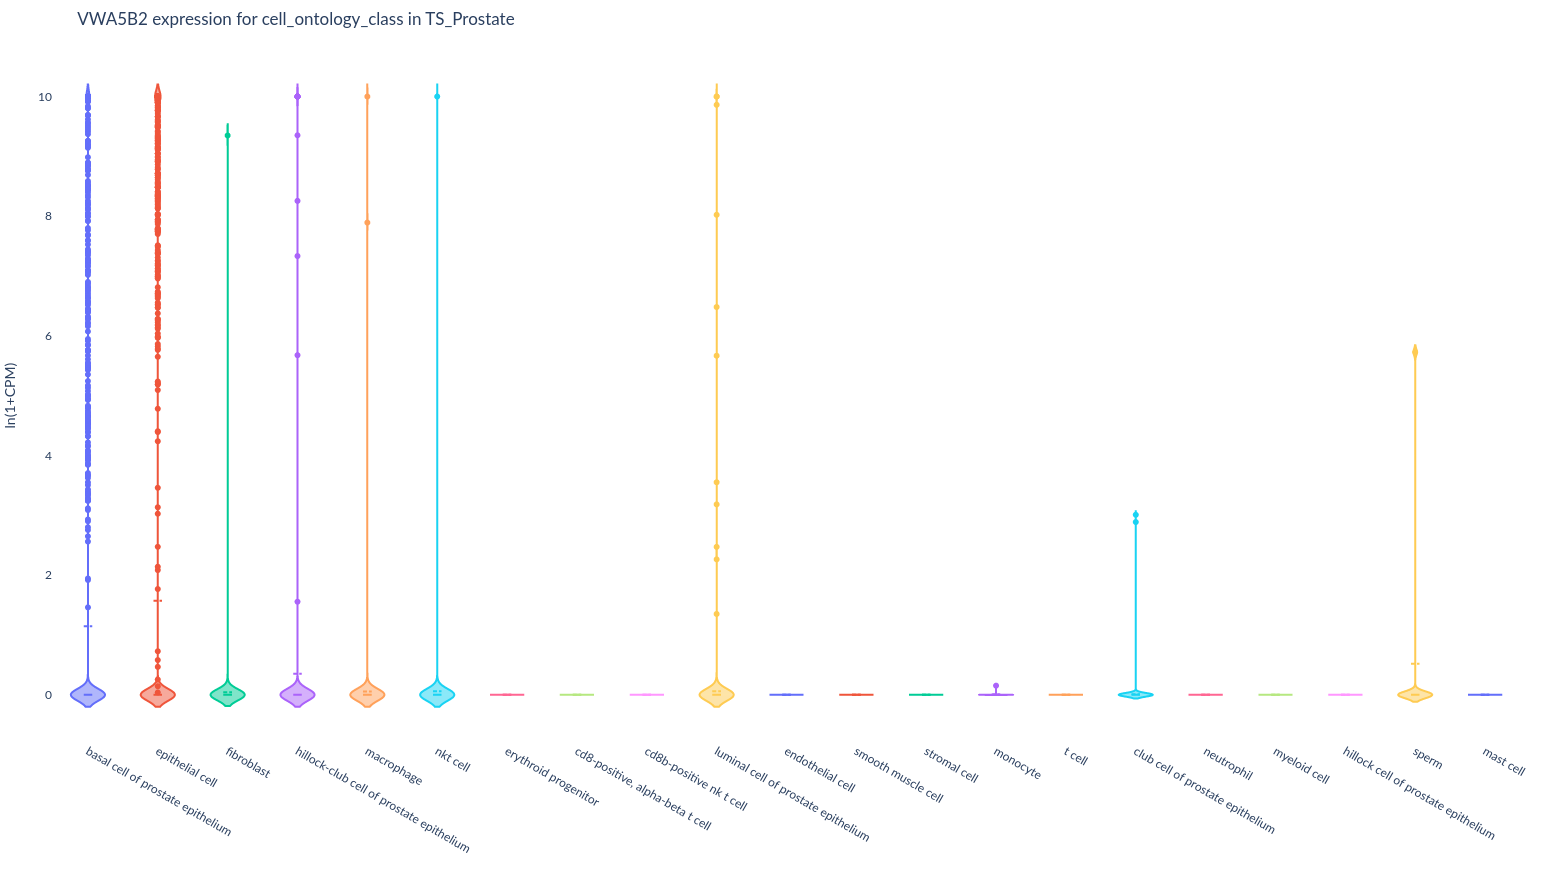

Clearly, these are some quite anomalous distributions, which will be investigated further.